In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27)
torch.manual_seed(27)

In [3]:
#DEVICE = swyft.set_device(gpu=True)
DEVICE = 'cuda'

In [4]:
def model(params):
    a = params['a']
    b = params['b']
    x=np.array([a,2*(b-a)])
    return dict(mu=x)

def noise(obs, params, noise = 0.01):
    x = obs['mu']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

par0 = dict(a=0.55, b=0.45)
obs0 = model(par0)

In [5]:
prior = swyft.Prior({"a": ["uniform", 0., 1.], "b": ["uniform",  0., 1.]})

In [6]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE)

In [7]:
s.run()

Simulate: 100%|██████████| 31095/31095 [00:25<00:00, 1199.24it/s]


In [8]:
post = s.gen_2d_marginals(N = 15000)

Simulate: 100%|██████████| 33/33 [00:00<00:00, 1234.58it/s]


In [9]:
samples = post(obs0, 1000000);

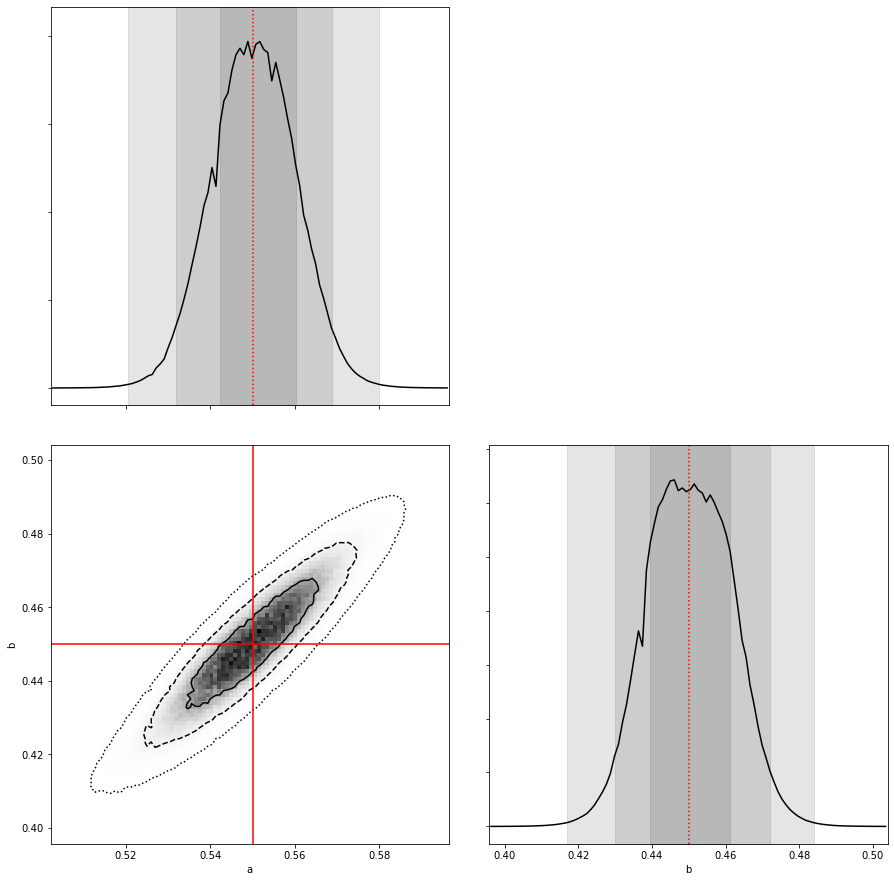

In [10]:
swyft.corner(samples, ["a", "b"], color='k', figsize = (15,15), truth=par0)